# FMA - What to Play Next? - Ensemble Models

In [1]:
import time
import os

import IPython.display as ipd
from IPython.display import *
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import utils

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics

from catboost import CatBoostClassifier
import collections
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
## This is just to make plots appear in the notebook
#%matplotlib inline

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "7" #please put your GPU

In [3]:
tracks = utils.load('../data/tracks.csv')
features = utils.load('../data/features.csv')
echonest = utils.load('../data/echonest.csv')
genres = utils.load('../data/genres.csv')

tracks.shape, features.shape, echonest.shape, genres.shape

((106574, 52), (106574, 518), (13129, 249), (163, 4))

In [4]:
# !ls /aml/notebook/audio/fma_small/153
# Audio("/aml/notebook/audio/fma_small/153/153955.mp3", autoplay=True)

# Preprocessing

In [5]:
def preprocess(df):
    # Add genre_top, split, subset from track to features
    df_tracks = tracks
    genre_top = df_tracks.track.genre_top
    split = df_tracks.set.split
    subset = df_tracks.set.subset
    df = pd.concat([df, genre_top, split, subset], axis=1)
    df = df.dropna(subset=['genre_top'])
    
    # Remove genres with less than 1000 entries
    counts = df['genre_top'].value_counts()
    df = df[~df['genre_top'].isin(counts[counts < 1000].index)]
    df.genre_top.unique()
    return df


def oversampling(X, y):
    print('before oversampling:', collections.Counter(y))
    
    oversample = RandomOverSampler(sampling_strategy='auto')
    X_over, y_over = oversample.fit_resample(X, y)
    a = np.array(y_over)
    print('after oversampling:', collections.Counter(a))
    
    y_over = pd.Series(y_over)
    return X_over, y_over


def undersampling(X, y):
    print('before undersampling:', collections.Counter(y))
    
    undersample = RandomUnderSampler(sampling_strategy='auto')
    X_under, y_under = undersample.fit_resample(X, y)
    a = np.array(y_under)
    print('after undersampling:', collections.Counter(a))
    
    y_under = pd.Series(y_under)
    return X_under, y_under


def mixsampling(X, y):
    strategy = {'Hip-Hop':6000, 'Folk':6000, 'Pop':6000, 'Instrumental':6000, 'Classical':6000, 'International':6000}
    print('before sampling:', collections.Counter(y))
    #smote=SMOTE(sampling_strategy=strategy)
    #X, y=smote.fit_resample(X, y)
    oversample = RandomOverSampler(sampling_strategy=strategy)
    X, y = oversample.fit_resample(X, y)
    print('after oversampling:', collections.Counter(y))
    
    strategy = {'Rock':6000, 'Experimental':6000, 'Electronic':6000}
    undersample = RandomUnderSampler(sampling_strategy=strategy)
    X, y = undersample.fit_resample(X, y)
    print('after undersampling:', collections.Counter(y))
    return X, y


def apply_PCA(df):   
    # Keep needed features, to be added back after PCA
    genre_top = df.genre_top
    index = df.index
    split = df.split
    subset = df.subset
    df = df.drop(columns=['genre_top', 'split', 'subset'])

    # Scale the features and set the values to a new variable
    scaler = StandardScaler()
    scaled_train_features = scaler.fit_transform(df)
    
    # Get our explained variance ratios from PCA using all features
    pca = PCA(n_components = 0.95)
    pca.fit(scaled_train_features)
    exp_variance = pca.explained_variance_ratio_
    reduced = pca.transform(scaled_train_features)

    # plot the explained variance using a barplot
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.bar(range(pca.n_components_), exp_variance)
    ax.set_xlabel('Principal Component #')
    
    df = pd.DataFrame(reduced)
    df.index = index
    df = pd.concat([df, genre_top, split, subset], axis=1)
    return df


In [6]:
df_processed = preprocess(features)
#df_postPCA = apply_PCA(df_processed)
df_small = df_processed[df_processed.subset == 'small']

X = df_small.drop(columns=['genre_top', 'split', 'subset'])
y = df_small['genre_top']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

# Test on small dataset

In [7]:
# DataFrame for storing test results
metrics_col = ['model', 'accuracy', 'precision', 'recall', 'f1_score', 'ROCAUC']
df_metrics = pd.DataFrame(columns = metrics_col)


---CatBoost on small subset---
accuracy: 0.615
precision: 0.6163
recall: 0.615
f1 score: 0.6144
AUC: 0.9083


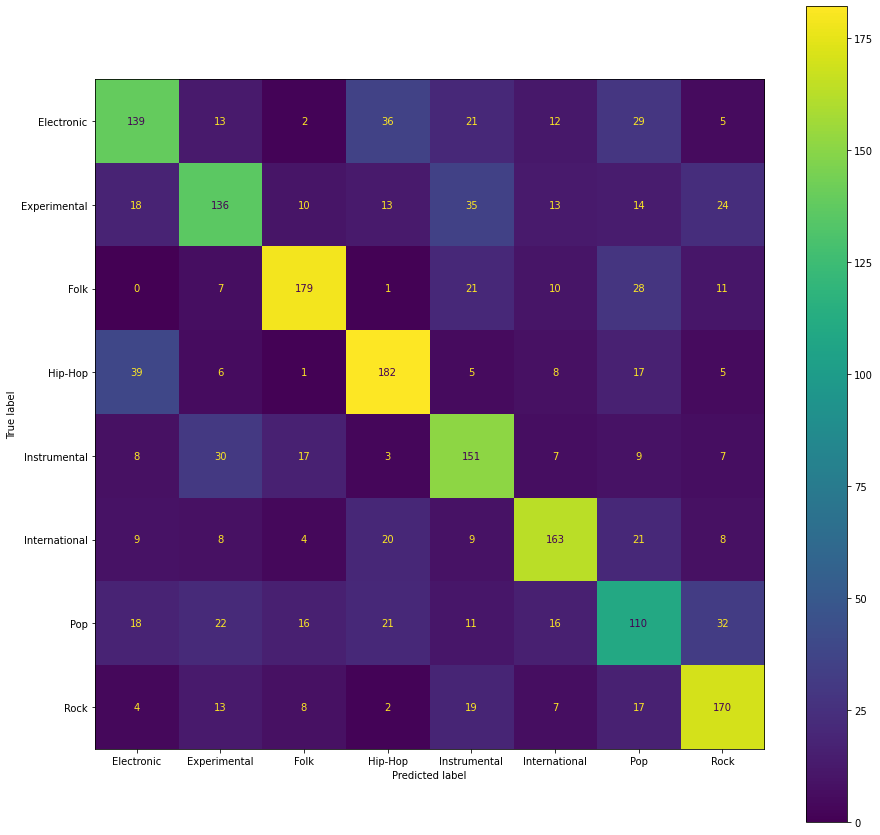

In [8]:
#train test split of df_small
cat_small = CatBoostClassifier(verbose=False)
cat_small.fit(X_train, y_train, [])
y_pred = cat_small.predict(X_test)
y_pred_proba = cat_small.predict_proba(X_test)

model = 'test_small'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on small subset---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)

fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cat_small, X_test, y_test, ax=ax) 

# Split to train, test and validation dataset

In [9]:
# Train on full set
df_processed = preprocess(features)
#df_postPCA = apply_PCA(df_processed)
df_train = df_processed[df_processed.split == 'training']
df_test = df_processed[df_processed.split == 'test']
df_validation = df_processed[df_processed.split == 'validation']

X_train = df_train.drop(columns=['genre_top', 'split', 'subset'])
y_train = df_train['genre_top']
X_test = df_test.drop(columns=['genre_top', 'split', 'subset'])
y_test = df_test['genre_top']
X_validation = df_validation.drop(columns=['genre_top', 'split', 'subset'])
y_validation = df_validation['genre_top']

# Over vs under vs mix vs no sampling

#### No Sampling


---CatBoost on full subset w no sampling---
accuracy: 0.6568
precision: 0.6329
recall: 0.6568
f1 score: 0.6298
AUC: 0.9085


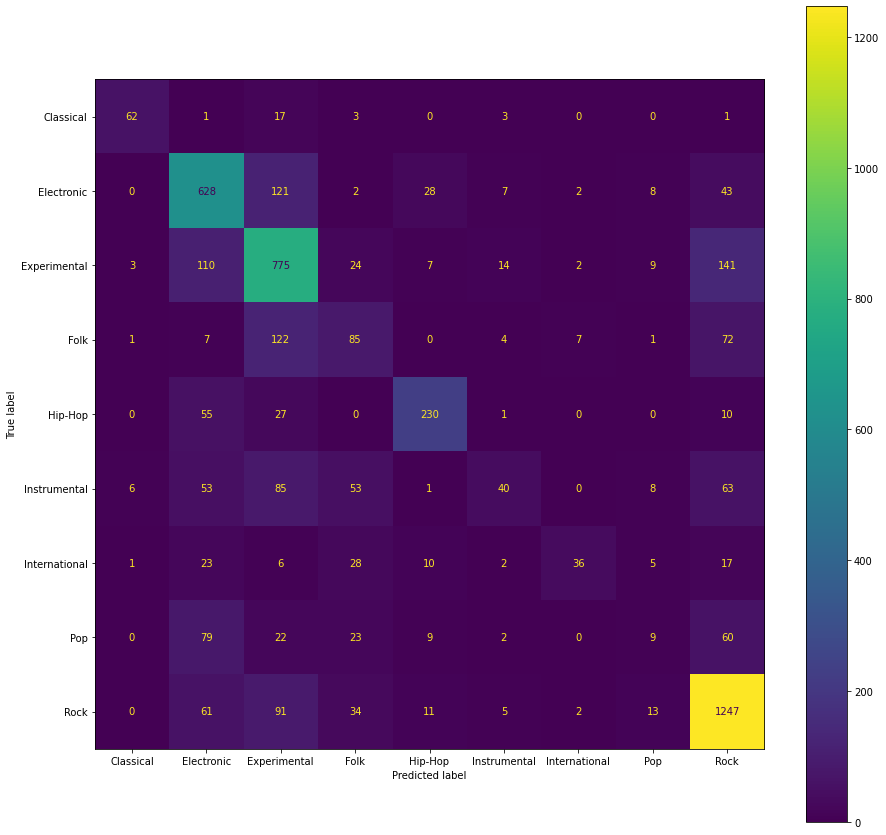

In [10]:
#train and test on full dataset
cat_full = CatBoostClassifier(verbose=False)
cat_full.fit(X_train, y_train, [])
y_pred = cat_full.predict(X_test)
y_pred_proba = cat_full.predict_proba(X_test)

model = 'CatBoost(no sampling)'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on full subset w no sampling---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cat_full, X_test, y_test, ax=ax) 

#### Oversampling

before oversampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 2910, 'Folk': 2275, 'Pop': 1815, 'Instrumental': 1579, 'International': 1124, 'Classical': 1069})
after oversampling: Counter({'Hip-Hop': 11394, 'Pop': 11394, 'Rock': 11394, 'Experimental': 11394, 'Folk': 11394, 'Electronic': 11394, 'International': 11394, 'Classical': 11394, 'Instrumental': 11394})

---CatBoost on full subset w over sampling---
accuracy: 0.6477
precision: 0.6492
recall: 0.6477
f1 score: 0.6473
AUC: 0.9048


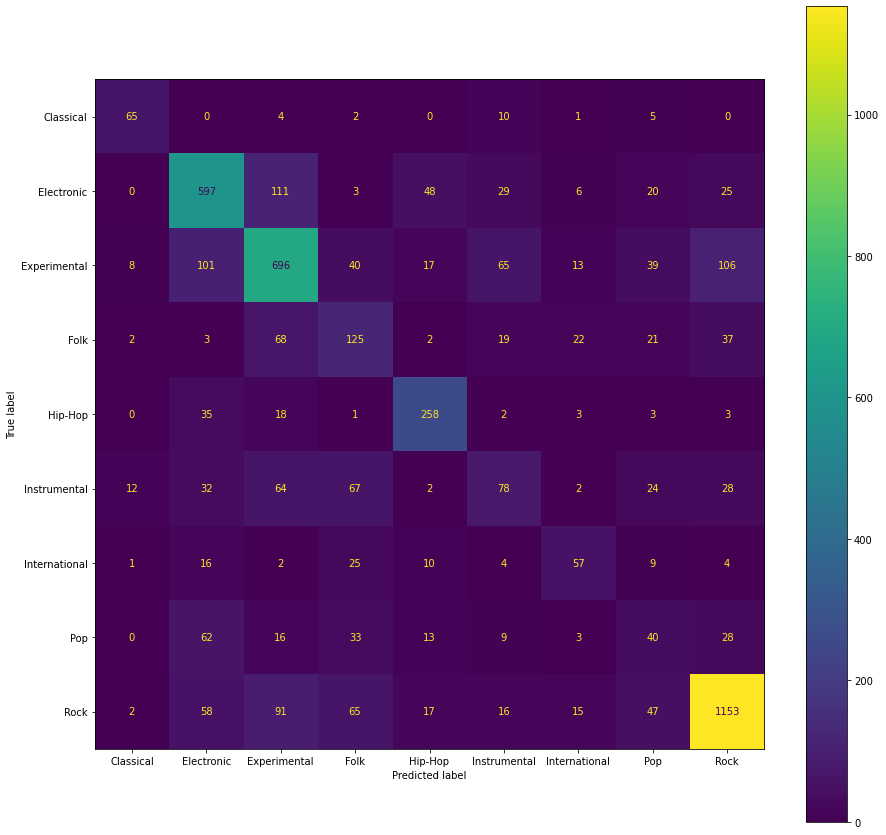

In [11]:
# Train on full set w oversampling
X_over, y_over = oversampling(X_train, y_train)

#train and test on full dataset w oversampling(training)
cat_over = CatBoostClassifier(verbose=False)
cat_over.fit(X_over, y_over, [])
y_pred = cat_over.predict(X_test)
y_pred_proba = cat_over.predict_proba(X_test)

model = 'CatBoost(over sampling)'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on full subset w over sampling---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cat_over, X_test, y_test, ax=ax) 

#### Undersampling

before undersampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 2910, 'Folk': 2275, 'Pop': 1815, 'Instrumental': 1579, 'International': 1124, 'Classical': 1069})
after undersampling: Counter({'Classical': 1069, 'Electronic': 1069, 'Experimental': 1069, 'Folk': 1069, 'Hip-Hop': 1069, 'Instrumental': 1069, 'International': 1069, 'Pop': 1069, 'Rock': 1069})

---CatBoost on full subset w under sampling---
accuracy: 0.5821
precision: 0.6381
recall: 0.5821
f1 score: 0.6005
AUC: 0.8867


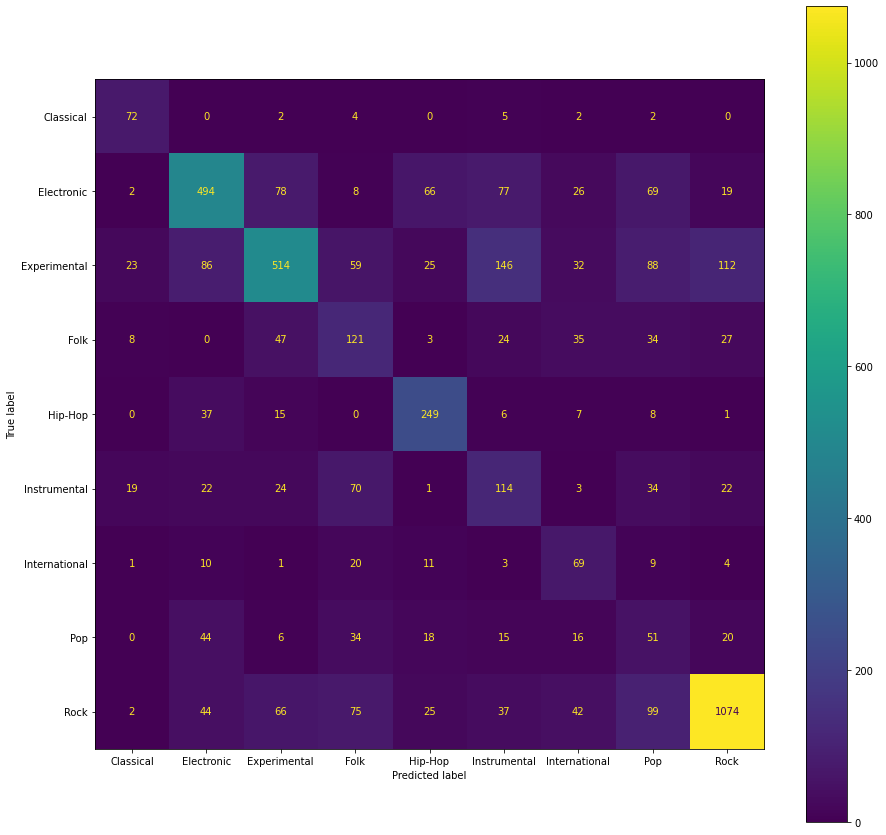

In [12]:
# Train on full set w undersampling
X_under, y_under = undersampling(X_train, y_train)

#train and test on full dataset w undersampling(training)
cat_under = CatBoostClassifier(verbose=False)
cat_under.fit(X_under, y_under, [])
y_pred = cat_under.predict(X_test)
y_pred_proba = cat_under.predict_proba(X_test)

model = 'CatBoost(under sampling)'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on full subset w under sampling---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cat_under, X_test, y_test, ax=ax) 

#### Mix sampling

before sampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 2910, 'Folk': 2275, 'Pop': 1815, 'Instrumental': 1579, 'International': 1124, 'Classical': 1069})
after oversampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 6000, 'Pop': 6000, 'Folk': 6000, 'International': 6000, 'Classical': 6000, 'Instrumental': 6000})
after undersampling: Counter({'Classical': 6000, 'Electronic': 6000, 'Experimental': 6000, 'Folk': 6000, 'Hip-Hop': 6000, 'Instrumental': 6000, 'International': 6000, 'Pop': 6000, 'Rock': 6000})

---CatBoost on full subset w over sampling---
accuracy: 0.6353
precision: 0.6466
recall: 0.6353
f1 score: 0.6394
AUC: 0.902


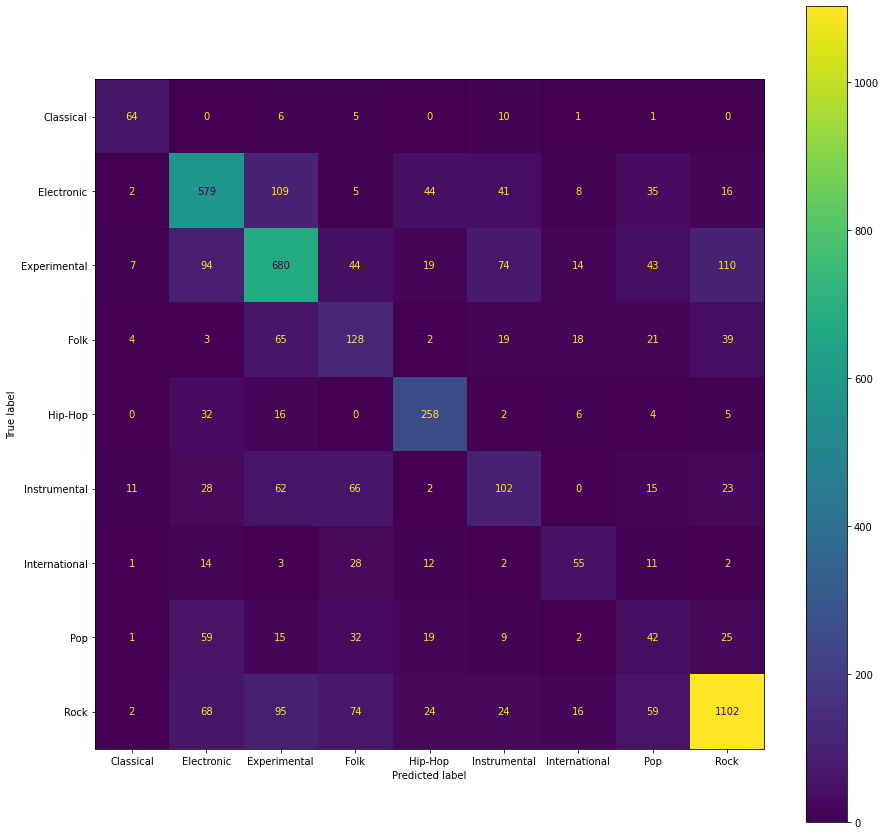

In [13]:
# Train on full set w mix sampling
X_mix, y_mix = mixsampling(X_train, y_train)

#train and test on full dataset w mix sampling(training)
cat_mix = CatBoostClassifier(verbose=False)
cat_mix.fit(X_mix, y_mix, [])
y_pred = cat_mix.predict(X_test)
y_pred_proba = cat_mix.predict_proba(X_test)

model = 'CatBoost(over sampling)'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on full subset w over sampling---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cat_mix, X_test, y_test, ax=ax) 

# Random Forest vs XGBoost vs CatBoost

#### Random Forest

best score: 0.5878337892405887
best parameters:  {'max_depth': 11, 'n_estimators': 500}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



---Random Forest w hyperparemeter tuning---
accuracy: 0.6243
precision: 0.5756
recall: 0.6243
f1 score: 0.5761
AUC: 0.8828


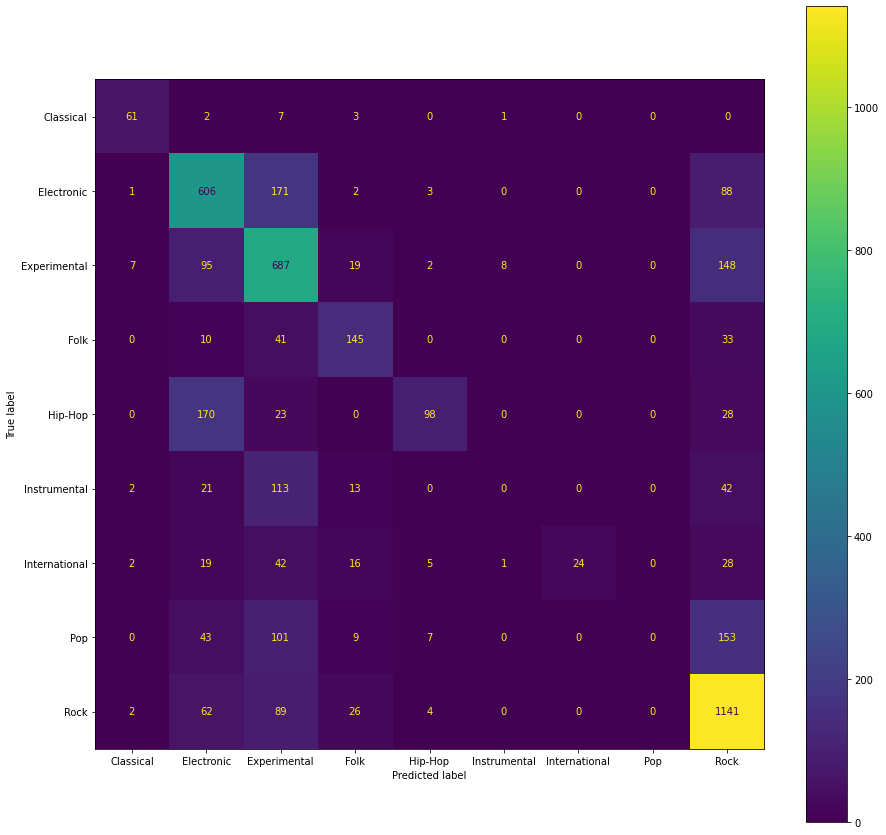

In [14]:
# To get best randomforest classifier after hyperparameter tuning(df_medium)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [10, 50, 100, 500],
             'max_depth': [5, 7, 9, 11]}
gridsearch_clf = GridSearchCV(estimator=rf_clf, param_grid=parameters, cv=3)
gridsearch_clf.fit(X_train, y_train)

print('best score:', gridsearch_clf.best_score_)
print('best parameters: ', gridsearch_clf.best_params_)
rf_clf_best = RandomForestClassifier(max_depth=gridsearch_clf.best_params_['max_depth'], 
                                     n_estimators=gridsearch_clf.best_params_['n_estimators'])

rf_clf_best.fit(X_train,y_train)
y_pred = rf_clf_best.predict(X_validation)
y_pred_proba = rf_clf_best.predict_proba(X_validation)

model = 'Random Forest(w hyperparemeter tuning)'
accuracy = round(metrics.accuracy_score(y_validation, y_pred),4)
precision = round(metrics.precision_score(y_validation, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_validation, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_validation, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_validation, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---Random Forest w hyperparemeter tuning---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(rf_clf_best, X_validation, y_validation, ax=ax)

#### XGBoost

In [19]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xg_clf = xgb.XGBClassifier(eval_metric='mlogloss')
parameters = {"learning_rate"    : [0.01, 0.1],
              "max_depth"        : [ 5, 7, 10],
              "gamma"            : [ 0.1, 0.2 ]}
randomsearch_clf = RandomizedSearchCV(xg_clf, parameters, cv=3)
randomsearch_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClas

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                     

In [20]:
print('best score:', randomsearch_clf.best_score_)
print('best parameters: ', randomsearch_clf.best_params_)

best score: 0.6349615735313273
best parameters:  {'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2}


In [ ]:
xg_clf_best = xgb.XGBClassifier(learning_rate=randomsearch_clf.best_params_['learning_rate'], 
                                     max_depth=randomsearch_clf.best_params_['max_depth'], 
                                     gamma=randomsearch_clf.best_params_['gamma'])

xg_clf_best.fit(X_train,y_train)
y_pred = xg_clf_best.predict(X_validation)
y_pred_proba = xg_clf_best.predict_proba(X_validation)

model = 'XGBoost(w hyperparemeter tuning)'
accuracy = round(metrics.accuracy_score(y_validation, y_pred),4)
precision = round(metrics.precision_score(y_validation, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_validation, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_validation, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_validation, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---XGBoost w hyperparemeter tuning---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xg_clf_best, X_validation, y_validation, ax=ax)

[04:16:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### CatBoost

best score: 0.6504884720593983
best parameters:  {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'depth': 6}
0:	learn: 2.0252756	total: 219ms	remaining: 3m 39s
1:	learn: 1.9114285	total: 486ms	remaining: 4m 2s
2:	learn: 1.8326041	total: 750ms	remaining: 4m 9s
3:	learn: 1.7591354	total: 1.02s	remaining: 4m 13s
4:	learn: 1.7027594	total: 1.29s	remaining: 4m 16s
5:	learn: 1.6556569	total: 1.55s	remaining: 4m 16s
6:	learn: 1.6129853	total: 1.8s	remaining: 4m 14s
7:	learn: 1.5737776	total: 2.04s	remaining: 4m 12s
8:	learn: 1.5425599	total: 2.28s	remaining: 4m 11s
9:	learn: 1.5163266	total: 2.55s	remaining: 4m 12s
10:	learn: 1.4908802	total: 2.83s	remaining: 4m 14s
11:	learn: 1.4684962	total: 3.08s	remaining: 4m 13s
12:	learn: 1.4471695	total: 3.35s	remaining: 4m 14s
13:	learn: 1.4273076	total: 3.6s	remaining: 4m 13s
14:	learn: 1.4104498	total: 3.83s	remaining: 4m 11s
15:	learn: 1.3954824	total: 4.08s	remaining: 4m 11s
16:	learn: 1.3809614	total: 4.33s	remaining: 4m 10s
17:	learn: 1.3671779	total: 

156:	learn: 0.9441492	total: 37.5s	remaining: 3m 21s
157:	learn: 0.9422886	total: 37.8s	remaining: 3m 21s
158:	learn: 0.9414622	total: 38s	remaining: 3m 21s
159:	learn: 0.9403670	total: 38.2s	remaining: 3m 20s
160:	learn: 0.9394188	total: 38.5s	remaining: 3m 20s
161:	learn: 0.9377144	total: 38.7s	remaining: 3m 20s
162:	learn: 0.9367950	total: 39s	remaining: 3m 20s
163:	learn: 0.9353046	total: 39.2s	remaining: 3m 19s
164:	learn: 0.9343023	total: 39.4s	remaining: 3m 19s
165:	learn: 0.9332540	total: 39.7s	remaining: 3m 19s
166:	learn: 0.9319436	total: 39.9s	remaining: 3m 18s
167:	learn: 0.9307075	total: 40.1s	remaining: 3m 18s
168:	learn: 0.9296978	total: 40.3s	remaining: 3m 18s
169:	learn: 0.9286074	total: 40.6s	remaining: 3m 18s
170:	learn: 0.9274382	total: 40.8s	remaining: 3m 17s
171:	learn: 0.9259535	total: 41s	remaining: 3m 17s
172:	learn: 0.9248180	total: 41.3s	remaining: 3m 17s
173:	learn: 0.9238968	total: 41.5s	remaining: 3m 17s
174:	learn: 0.9233205	total: 41.7s	remaining: 3m 16s

312:	learn: 0.8090369	total: 1m 13s	remaining: 2m 40s
313:	learn: 0.8081801	total: 1m 13s	remaining: 2m 40s
314:	learn: 0.8076936	total: 1m 13s	remaining: 2m 39s
315:	learn: 0.8070205	total: 1m 13s	remaining: 2m 39s
316:	learn: 0.8063874	total: 1m 13s	remaining: 2m 39s
317:	learn: 0.8054662	total: 1m 14s	remaining: 2m 39s
318:	learn: 0.8049191	total: 1m 14s	remaining: 2m 38s
319:	learn: 0.8043927	total: 1m 14s	remaining: 2m 38s
320:	learn: 0.8036142	total: 1m 14s	remaining: 2m 38s
321:	learn: 0.8028235	total: 1m 15s	remaining: 2m 38s
322:	learn: 0.8023601	total: 1m 15s	remaining: 2m 37s
323:	learn: 0.8017139	total: 1m 15s	remaining: 2m 37s
324:	learn: 0.8014104	total: 1m 15s	remaining: 2m 37s
325:	learn: 0.8008516	total: 1m 16s	remaining: 2m 37s
326:	learn: 0.8001573	total: 1m 16s	remaining: 2m 36s
327:	learn: 0.7995281	total: 1m 16s	remaining: 2m 36s
328:	learn: 0.7988062	total: 1m 16s	remaining: 2m 36s
329:	learn: 0.7980825	total: 1m 16s	remaining: 2m 36s
330:	learn: 0.7976180	total:

465:	learn: 0.7203814	total: 1m 47s	remaining: 2m 3s
466:	learn: 0.7198729	total: 1m 48s	remaining: 2m 3s
467:	learn: 0.7195027	total: 1m 48s	remaining: 2m 3s
468:	learn: 0.7192628	total: 1m 48s	remaining: 2m 2s
469:	learn: 0.7188513	total: 1m 48s	remaining: 2m 2s
470:	learn: 0.7182714	total: 1m 48s	remaining: 2m 2s
471:	learn: 0.7179087	total: 1m 49s	remaining: 2m 2s
472:	learn: 0.7175779	total: 1m 49s	remaining: 2m 1s
473:	learn: 0.7169033	total: 1m 49s	remaining: 2m 1s
474:	learn: 0.7163992	total: 1m 49s	remaining: 2m 1s
475:	learn: 0.7158511	total: 1m 50s	remaining: 2m 1s
476:	learn: 0.7155291	total: 1m 50s	remaining: 2m
477:	learn: 0.7152476	total: 1m 50s	remaining: 2m
478:	learn: 0.7146193	total: 1m 50s	remaining: 2m
479:	learn: 0.7143363	total: 1m 50s	remaining: 2m
480:	learn: 0.7138152	total: 1m 51s	remaining: 1m 59s
481:	learn: 0.7134068	total: 1m 51s	remaining: 1m 59s
482:	learn: 0.7129330	total: 1m 51s	remaining: 1m 59s
483:	learn: 0.7124645	total: 1m 51s	remaining: 1m 59s
4

619:	learn: 0.6504756	total: 2m 22s	remaining: 1m 27s
620:	learn: 0.6500746	total: 2m 22s	remaining: 1m 27s
621:	learn: 0.6499335	total: 2m 23s	remaining: 1m 26s
622:	learn: 0.6493270	total: 2m 23s	remaining: 1m 26s
623:	learn: 0.6488125	total: 2m 23s	remaining: 1m 26s
624:	learn: 0.6482124	total: 2m 23s	remaining: 1m 26s
625:	learn: 0.6478759	total: 2m 23s	remaining: 1m 25s
626:	learn: 0.6473868	total: 2m 24s	remaining: 1m 25s
627:	learn: 0.6469767	total: 2m 24s	remaining: 1m 25s
628:	learn: 0.6463628	total: 2m 24s	remaining: 1m 25s
629:	learn: 0.6458591	total: 2m 24s	remaining: 1m 25s
630:	learn: 0.6454734	total: 2m 25s	remaining: 1m 24s
631:	learn: 0.6450841	total: 2m 25s	remaining: 1m 24s
632:	learn: 0.6447091	total: 2m 25s	remaining: 1m 24s
633:	learn: 0.6440620	total: 2m 25s	remaining: 1m 24s
634:	learn: 0.6436485	total: 2m 26s	remaining: 1m 23s
635:	learn: 0.6432977	total: 2m 26s	remaining: 1m 23s
636:	learn: 0.6428308	total: 2m 26s	remaining: 1m 23s
637:	learn: 0.6422514	total:

773:	learn: 0.5899165	total: 2m 57s	remaining: 51.9s
774:	learn: 0.5896233	total: 2m 57s	remaining: 51.6s
775:	learn: 0.5893036	total: 2m 58s	remaining: 51.4s
776:	learn: 0.5888757	total: 2m 58s	remaining: 51.2s
777:	learn: 0.5886249	total: 2m 58s	remaining: 50.9s
778:	learn: 0.5883759	total: 2m 58s	remaining: 50.7s
779:	learn: 0.5879710	total: 2m 58s	remaining: 50.5s
780:	learn: 0.5875583	total: 2m 59s	remaining: 50.3s
781:	learn: 0.5872298	total: 2m 59s	remaining: 50s
782:	learn: 0.5869498	total: 2m 59s	remaining: 49.8s
783:	learn: 0.5866299	total: 2m 59s	remaining: 49.6s
784:	learn: 0.5863262	total: 3m	remaining: 49.3s
785:	learn: 0.5860685	total: 3m	remaining: 49.1s
786:	learn: 0.5855435	total: 3m	remaining: 48.9s
787:	learn: 0.5850307	total: 3m	remaining: 48.7s
788:	learn: 0.5847340	total: 3m 1s	remaining: 48.4s
789:	learn: 0.5843275	total: 3m 1s	remaining: 48.2s
790:	learn: 0.5838026	total: 3m 1s	remaining: 48s
791:	learn: 0.5834574	total: 3m 1s	remaining: 47.7s
792:	learn: 0.583

930:	learn: 0.5374285	total: 3m 33s	remaining: 15.8s
931:	learn: 0.5372050	total: 3m 33s	remaining: 15.6s
932:	learn: 0.5369792	total: 3m 33s	remaining: 15.3s
933:	learn: 0.5365745	total: 3m 33s	remaining: 15.1s
934:	learn: 0.5360380	total: 3m 34s	remaining: 14.9s
935:	learn: 0.5356669	total: 3m 34s	remaining: 14.7s
936:	learn: 0.5353606	total: 3m 34s	remaining: 14.4s
937:	learn: 0.5349374	total: 3m 34s	remaining: 14.2s
938:	learn: 0.5346820	total: 3m 35s	remaining: 14s
939:	learn: 0.5342397	total: 3m 35s	remaining: 13.7s
940:	learn: 0.5339871	total: 3m 35s	remaining: 13.5s
941:	learn: 0.5336326	total: 3m 35s	remaining: 13.3s
942:	learn: 0.5334190	total: 3m 36s	remaining: 13.1s
943:	learn: 0.5331133	total: 3m 36s	remaining: 12.8s
944:	learn: 0.5326631	total: 3m 36s	remaining: 12.6s
945:	learn: 0.5324609	total: 3m 36s	remaining: 12.4s
946:	learn: 0.5320480	total: 3m 36s	remaining: 12.1s
947:	learn: 0.5317815	total: 3m 37s	remaining: 11.9s
948:	learn: 0.5315369	total: 3m 37s	remaining: 1

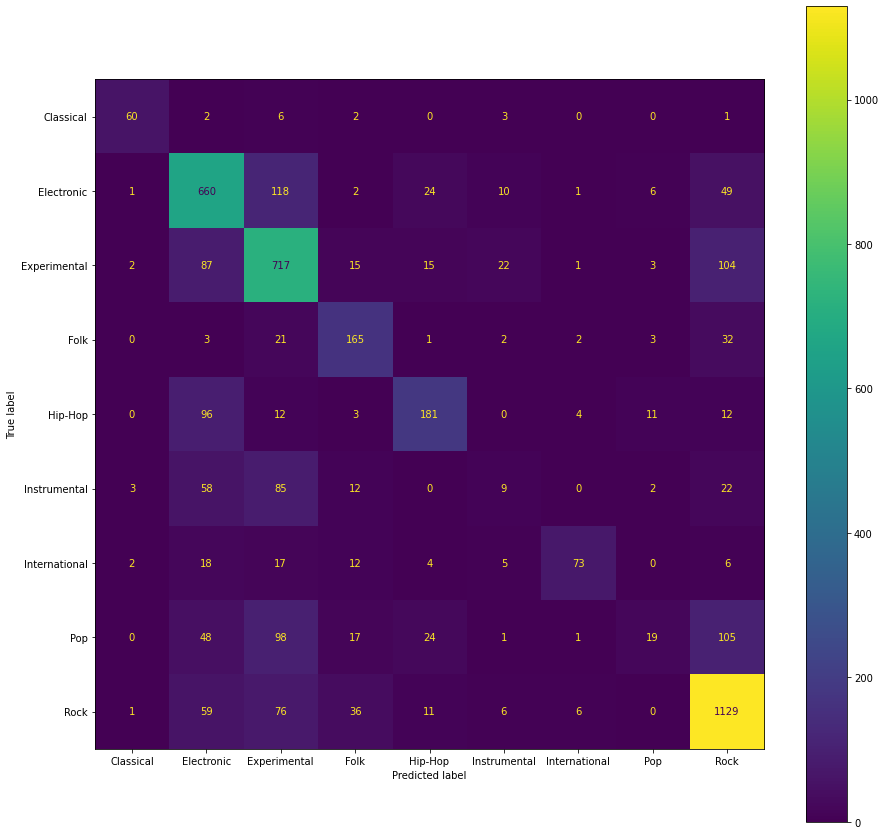

In [23]:
#train and test on full dataset
cat_clf = CatBoostClassifier(verbose=False)
parameters = {"learning_rate"    : [0.001, 0.01, 0.1],
              "depth"            : [4, 6, 10],
              "l2_leaf_reg"      : [1, 3, 5]}
randomsearch_clf = RandomizedSearchCV(cat_clf, parameters, cv=3)
randomsearch_clf.fit(X_train, y_train)

print('best score:', randomsearch_clf.best_score_)
print('best parameters: ', randomsearch_clf.best_params_)
cat_clf_best = CatBoostClassifier(learning_rate=randomsearch_clf.best_params_['learning_rate'], 
                                     depth=randomsearch_clf.best_params_['depth'], 
                                     l2_leaf_reg=randomsearch_clf.best_params_['l2_leaf_reg'])

cat_clf_best.fit(X_train, y_train, [])
y_pred = cat_clf_best.predict(X_validation)
y_pred_proba = cat_clf_best.predict_proba(X_validation)

model = 'CatBoost(w hyperparemeter tuning)'
accuracy = round(metrics.accuracy_score(y_validation, y_pred),4)
precision = round(metrics.precision_score(y_validation, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_validation, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_validation, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_validation, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost w hyperparemeter tuning---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cat_clf_best, X_validation, y_validation, ax=ax) 

In [40]:
sorted_class = ['Classical', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
np.argmax(y_pred_proba[0])

count=0
for i in range(5):
    score = y_pred_proba[i]
    print("Index: {}   Actual: {}   Predict: {}".format(y_test.index[i], y_test.iloc[i], sorted_class[np.argmax(score)]))
    #print("Top 3 predictions")
    sorted_a = np.argsort(-score, axis=-1, kind='quicksort', order=None)
    
    top5 = sorted_a[:3]
    for x in top5:
        print("{}%".format(np.round(100 * np.max(score[x]),2)), sorted_class[x])
        if x == 0:
            count+=1
    print()

Index: 181   Actual: Rock   Predict: Rock
52.43% Rock
17.0% Experimental
14.38% Folk

Index: 182   Actual: Rock   Predict: Experimental
50.45% Experimental
30.75% Rock
7.83% Electronic

Index: 183   Actual: Rock   Predict: Rock
39.61% Rock
27.68% Experimental
10.61% Pop

Index: 184   Actual: Rock   Predict: Rock
71.53% Rock
12.64% Experimental
8.46% Pop

Index: 562   Actual: Rock   Predict: Rock
53.69% Rock
17.87% Experimental
8.68% Instrumental



#### Test if PCA helps

|Metrics| No Sampling | oversampling | undersampling | mixsampling |
|---|---|---|---|---|
| Accuracy | 0.6568 | 0.6431 | 0.5756| 0.6393 | 
| Precision | 0.6329 | 0.6469 | 0.6368 | 0.6540 | 
| Recall | 0.6568 | 0.6431 | 0.5756 |  0.6393 | 
| F1 score | 0.6298 | 0.6436 | 0.5959 | 0.6450 | 
| AUC | 0.9085 | 0.9036 | 0.8861 | 0.9011 | 

#### Test sampling with CatBoost

|Metrics| No Sampling | oversampling | undersampling | mixsampling |
|---|---|---|---|---|
| Accuracy | 0.6568 | 0.6431 | 0.5756| 0.6393 | 
| Precision | 0.6329 | 0.6469 | 0.6368 | 0.6540 | 
| Recall | 0.6568 | 0.6431 | 0.5756 |  0.6393 | 
| F1 score | 0.6298 | 0.6436 | 0.5959 | 0.6450 | 
| AUC | 0.9085 | 0.9036 | 0.8861 | 0.9011 | 

#### Best scores of different Ensemble techniques

|Metrics| CatBoost | RandomForest | XGboost | 
|---|---|---|---|
| Accuracy | 0.6568 | 0.6431 | 0.6448 |
| Precision | 0.6329 | 0.6469 | 0.6225 |
| Recall | 0.6568 | 0.6431 | 0.6448 |
| F1 score | 0.6298 | 0.6436 | 0.6163 |
| AUC | 0.9085 | 0.9036 | 0.9019 |

In [25]:
df_metrics

,model,accuracy,precision,recall,f1_score,ROCAUC
0,test_small,0.6150,0.6163,0.6150,0.6144,0.9083
1,CatBoost(no sampling),0.6568,0.6329,0.6568,0.6298,0.9085
2,CatBoost(over sampling),0.6477,0.6492,0.6477,0.6473,0.9048
3,CatBoost(under sampling),0.5821,0.6381,0.5821,0.6005,0.8867
4,CatBoost(over sampling),0.6353,0.6466,0.6353,0.6394,0.9020
5,Random Forest(w hyperparemeter tuning),0.6243,0.5756,0.6243,0.5761,0.8828
6,XGBoost(w hyperparemeter tuning),0.6650,0.6317,0.6650,0.6292,0.9025
7,CatBoost(w hyperparemeter tuning),0.6811,0.6536,0.6811,0.6519,0.9103


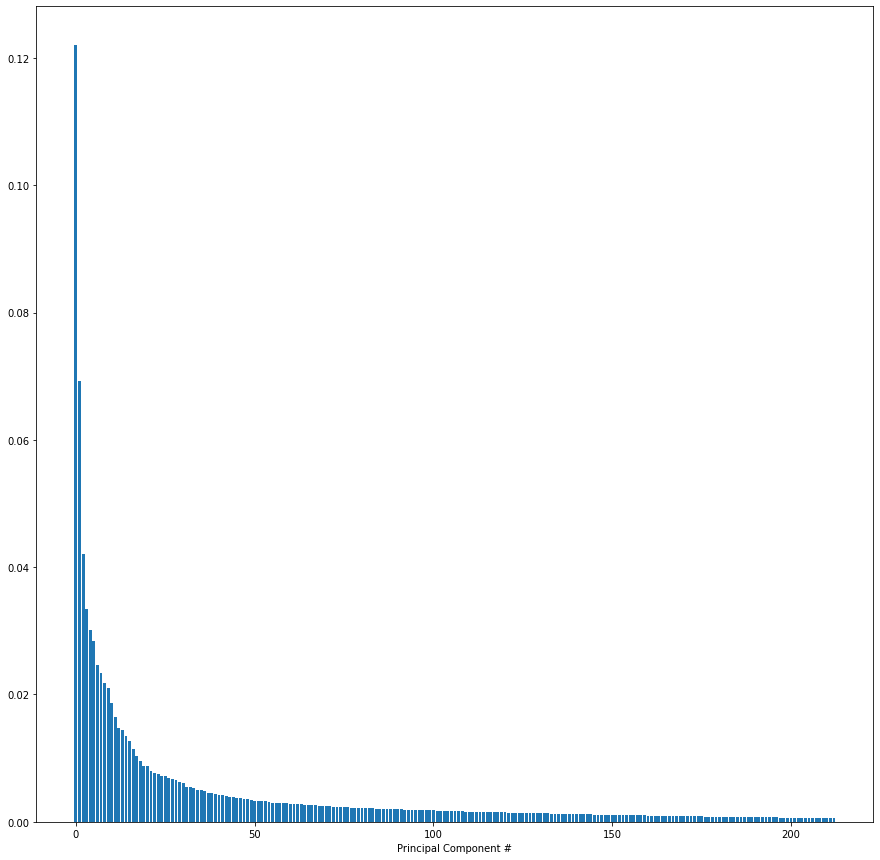

In [26]:
# Train on full set
df_processed = preprocess(features)
df_postPCA = apply_PCA(df_processed)
df_train = df_postPCA[df_postPCA.split == 'training']
df_test = df_postPCA[df_postPCA.split == 'test']
df_validation = df_postPCA[df_postPCA.split == 'test']

X_train = df_train.drop(columns=['genre_top', 'split', 'subset'])
y_train = df_train['genre_top']
X_test = df_test.drop(columns=['genre_top', 'split', 'subset'])
y_test = df_test['genre_top']
X_validation = df_validation.drop(columns=['genre_top', 'split', 'subset'])
y_validation = df_validation['genre_top']

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



---CatBoost on full subset w over sampling---
accuracy: 0.5401
precision: 0.4681
recall: 0.5401
f1 score: 0.4685
AUC: 0.8572


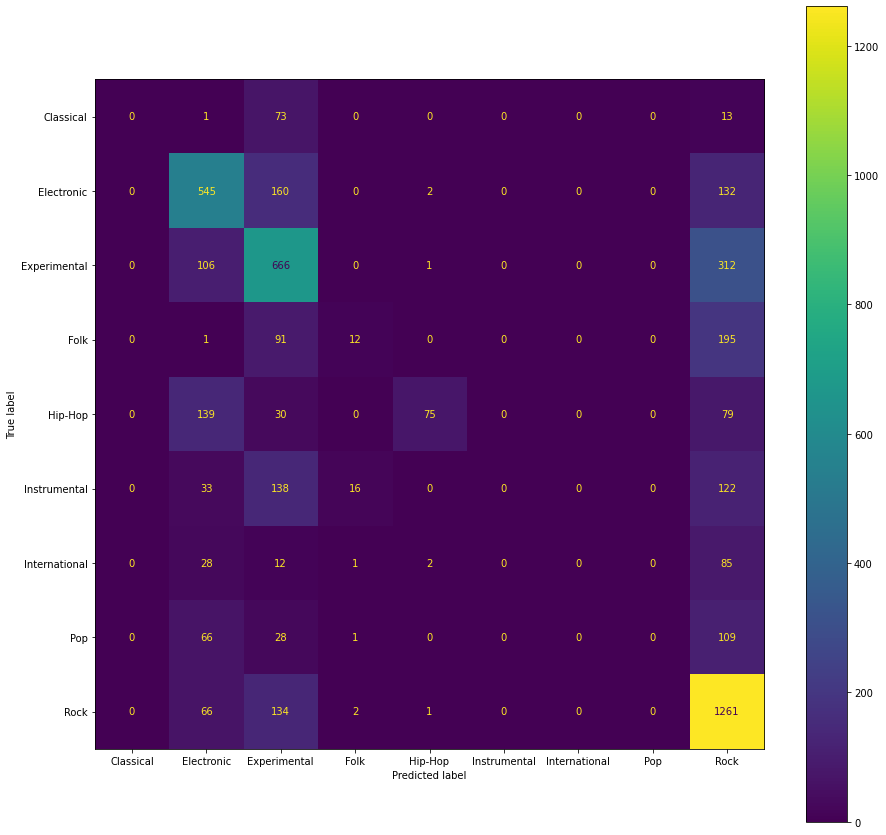

In [31]:
# train with PCA - Random Forest
rf_clf_best.fit(X_train, y_train)
y_pred = rf_clf_best.predict(X_validation)
y_pred_proba = rf_clf_best.predict_proba(X_validation)

model = 'Random Forest(w PCA)'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on full subset w over sampling---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(rf_clf_best, X_validation, y_validation, ax=ax) 

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

---CatBoost on full subset w over sampling---
accuracy: 0.6011
precision: 0.5787
recall: 0.6011
f1 score: 0.5644
AUC: 0.8759


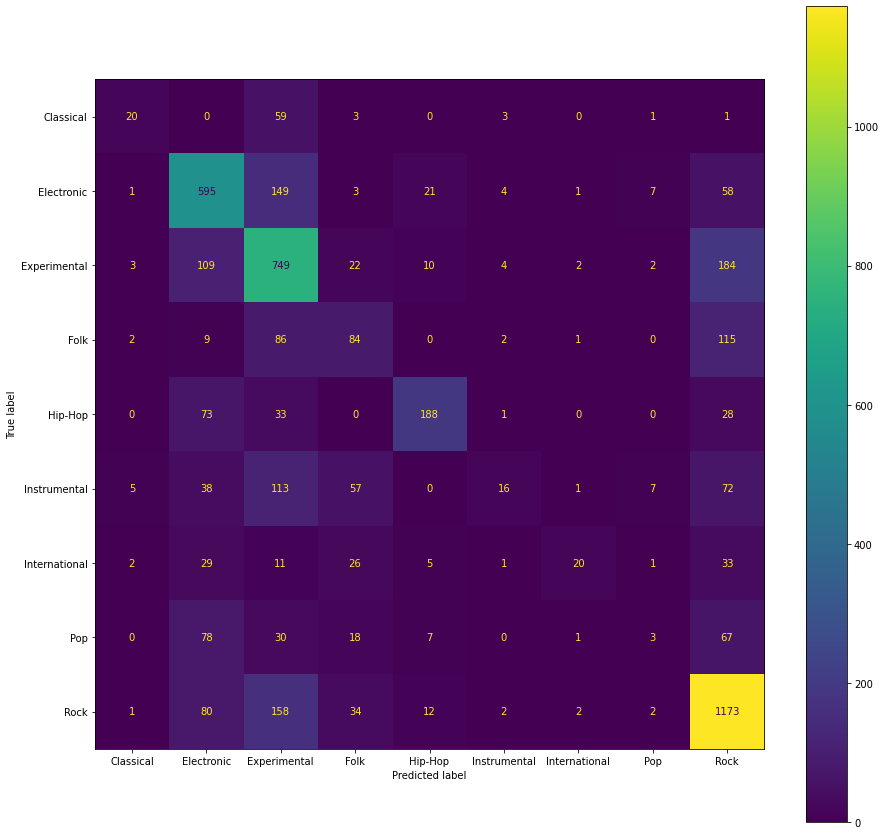

In [32]:
# train with PCA - XGBoost
xg_clf_best.fit(X_train, y_train)
y_pred = xg_clf_best.predict(X_validation)
y_pred_proba = xg_clf_best.predict_proba(X_validation)

model = 'XGBoost(w PCA)'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on full subset w over sampling---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xg_clf_best, X_validation, y_validation, ax=ax) 

0:	learn: 2.0461401	total: 140ms	remaining: 2m 19s
1:	learn: 1.9338035	total: 261ms	remaining: 2m 10s
2:	learn: 1.8505855	total: 381ms	remaining: 2m 6s
3:	learn: 1.7871875	total: 498ms	remaining: 2m 4s
4:	learn: 1.7379114	total: 609ms	remaining: 2m 1s
5:	learn: 1.6930403	total: 723ms	remaining: 1m 59s
6:	learn: 1.6531034	total: 840ms	remaining: 1m 59s
7:	learn: 1.6213010	total: 954ms	remaining: 1m 58s
8:	learn: 1.5905336	total: 1.06s	remaining: 1m 56s
9:	learn: 1.5656116	total: 1.17s	remaining: 1m 55s
10:	learn: 1.5409632	total: 1.28s	remaining: 1m 55s
11:	learn: 1.5209033	total: 1.39s	remaining: 1m 54s
12:	learn: 1.5017488	total: 1.51s	remaining: 1m 54s
13:	learn: 1.4862461	total: 1.63s	remaining: 1m 54s
14:	learn: 1.4686116	total: 1.74s	remaining: 1m 54s
15:	learn: 1.4533293	total: 1.86s	remaining: 1m 54s
16:	learn: 1.4398904	total: 1.98s	remaining: 1m 54s
17:	learn: 1.4268675	total: 2.09s	remaining: 1m 54s
18:	learn: 1.4167258	total: 2.21s	remaining: 1m 54s
19:	learn: 1.4055160	tota

158:	learn: 1.0177305	total: 17.4s	remaining: 1m 32s
159:	learn: 1.0164055	total: 17.6s	remaining: 1m 32s
160:	learn: 1.0149440	total: 17.7s	remaining: 1m 32s
161:	learn: 1.0139897	total: 17.8s	remaining: 1m 31s
162:	learn: 1.0129312	total: 17.9s	remaining: 1m 31s
163:	learn: 1.0115373	total: 18s	remaining: 1m 31s
164:	learn: 1.0105146	total: 18.1s	remaining: 1m 31s
165:	learn: 1.0095870	total: 18.2s	remaining: 1m 31s
166:	learn: 1.0081020	total: 18.3s	remaining: 1m 31s
167:	learn: 1.0067566	total: 18.4s	remaining: 1m 31s
168:	learn: 1.0057440	total: 18.5s	remaining: 1m 30s
169:	learn: 1.0046211	total: 18.6s	remaining: 1m 30s
170:	learn: 1.0034903	total: 18.7s	remaining: 1m 30s
171:	learn: 1.0021662	total: 18.8s	remaining: 1m 30s
172:	learn: 1.0008696	total: 18.9s	remaining: 1m 30s
173:	learn: 0.9993752	total: 19s	remaining: 1m 30s
174:	learn: 0.9982754	total: 19.1s	remaining: 1m 30s
175:	learn: 0.9971162	total: 19.2s	remaining: 1m 29s
176:	learn: 0.9959261	total: 19.3s	remaining: 1m 2

315:	learn: 0.8599075	total: 34.1s	remaining: 1m 13s
316:	learn: 0.8588902	total: 34.2s	remaining: 1m 13s
317:	learn: 0.8581913	total: 34.3s	remaining: 1m 13s
318:	learn: 0.8573001	total: 34.4s	remaining: 1m 13s
319:	learn: 0.8565428	total: 34.5s	remaining: 1m 13s
320:	learn: 0.8557442	total: 34.6s	remaining: 1m 13s
321:	learn: 0.8549401	total: 34.7s	remaining: 1m 13s
322:	learn: 0.8542664	total: 34.9s	remaining: 1m 13s
323:	learn: 0.8533563	total: 35s	remaining: 1m 12s
324:	learn: 0.8525302	total: 35.1s	remaining: 1m 12s
325:	learn: 0.8518894	total: 35.2s	remaining: 1m 12s
326:	learn: 0.8509854	total: 35.3s	remaining: 1m 12s
327:	learn: 0.8501667	total: 35.4s	remaining: 1m 12s
328:	learn: 0.8493378	total: 35.5s	remaining: 1m 12s
329:	learn: 0.8484858	total: 35.6s	remaining: 1m 12s
330:	learn: 0.8478787	total: 35.7s	remaining: 1m 12s
331:	learn: 0.8473987	total: 35.8s	remaining: 1m 12s
332:	learn: 0.8465888	total: 35.9s	remaining: 1m 11s
333:	learn: 0.8460608	total: 36s	remaining: 1m 1

474:	learn: 0.7487350	total: 50.7s	remaining: 56.1s
475:	learn: 0.7481311	total: 50.8s	remaining: 55.9s
476:	learn: 0.7476095	total: 50.9s	remaining: 55.8s
477:	learn: 0.7467820	total: 51s	remaining: 55.7s
478:	learn: 0.7461930	total: 51.1s	remaining: 55.6s
479:	learn: 0.7455199	total: 51.2s	remaining: 55.5s
480:	learn: 0.7447564	total: 51.3s	remaining: 55.4s
481:	learn: 0.7440402	total: 51.4s	remaining: 55.3s
482:	learn: 0.7433512	total: 51.6s	remaining: 55.2s
483:	learn: 0.7425952	total: 51.7s	remaining: 55.1s
484:	learn: 0.7417302	total: 51.8s	remaining: 55s
485:	learn: 0.7411371	total: 51.9s	remaining: 54.9s
486:	learn: 0.7405153	total: 52s	remaining: 54.8s
487:	learn: 0.7399141	total: 52.1s	remaining: 54.7s
488:	learn: 0.7392420	total: 52.2s	remaining: 54.6s
489:	learn: 0.7387498	total: 52.3s	remaining: 54.4s
490:	learn: 0.7381354	total: 52.4s	remaining: 54.3s
491:	learn: 0.7374190	total: 52.5s	remaining: 54.2s
492:	learn: 0.7369395	total: 52.6s	remaining: 54.1s
493:	learn: 0.7362

635:	learn: 0.6531686	total: 1m 7s	remaining: 38.8s
636:	learn: 0.6525837	total: 1m 7s	remaining: 38.7s
637:	learn: 0.6520686	total: 1m 8s	remaining: 38.6s
638:	learn: 0.6515725	total: 1m 8s	remaining: 38.5s
639:	learn: 0.6510107	total: 1m 8s	remaining: 38.4s
640:	learn: 0.6505661	total: 1m 8s	remaining: 38.3s
641:	learn: 0.6501130	total: 1m 8s	remaining: 38.2s
642:	learn: 0.6495859	total: 1m 8s	remaining: 38s
643:	learn: 0.6490229	total: 1m 8s	remaining: 37.9s
644:	learn: 0.6485845	total: 1m 8s	remaining: 37.8s
645:	learn: 0.6481921	total: 1m 8s	remaining: 37.7s
646:	learn: 0.6478054	total: 1m 8s	remaining: 37.6s
647:	learn: 0.6473609	total: 1m 9s	remaining: 37.5s
648:	learn: 0.6468001	total: 1m 9s	remaining: 37.4s
649:	learn: 0.6461331	total: 1m 9s	remaining: 37.3s
650:	learn: 0.6456754	total: 1m 9s	remaining: 37.2s
651:	learn: 0.6453288	total: 1m 9s	remaining: 37.1s
652:	learn: 0.6448215	total: 1m 9s	remaining: 37s
653:	learn: 0.6441883	total: 1m 9s	remaining: 36.9s
654:	learn: 0.64

791:	learn: 0.5785556	total: 1m 24s	remaining: 22.1s
792:	learn: 0.5779809	total: 1m 24s	remaining: 22s
793:	learn: 0.5776222	total: 1m 24s	remaining: 21.9s
794:	learn: 0.5772567	total: 1m 24s	remaining: 21.8s
795:	learn: 0.5769180	total: 1m 24s	remaining: 21.7s
796:	learn: 0.5766425	total: 1m 24s	remaining: 21.6s
797:	learn: 0.5763636	total: 1m 24s	remaining: 21.5s
798:	learn: 0.5759600	total: 1m 24s	remaining: 21.4s
799:	learn: 0.5754880	total: 1m 25s	remaining: 21.3s
800:	learn: 0.5750089	total: 1m 25s	remaining: 21.2s
801:	learn: 0.5744267	total: 1m 25s	remaining: 21.1s
802:	learn: 0.5739184	total: 1m 25s	remaining: 20.9s
803:	learn: 0.5734967	total: 1m 25s	remaining: 20.8s
804:	learn: 0.5730978	total: 1m 25s	remaining: 20.7s
805:	learn: 0.5725648	total: 1m 25s	remaining: 20.6s
806:	learn: 0.5722171	total: 1m 25s	remaining: 20.5s
807:	learn: 0.5718836	total: 1m 25s	remaining: 20.4s
808:	learn: 0.5714738	total: 1m 26s	remaining: 20.3s
809:	learn: 0.5711004	total: 1m 26s	remaining: 2

948:	learn: 0.5111904	total: 1m 40s	remaining: 5.42s
949:	learn: 0.5109257	total: 1m 41s	remaining: 5.32s
950:	learn: 0.5105914	total: 1m 41s	remaining: 5.21s
951:	learn: 0.5101431	total: 1m 41s	remaining: 5.11s
952:	learn: 0.5096004	total: 1m 41s	remaining: 5s
953:	learn: 0.5093190	total: 1m 41s	remaining: 4.89s
954:	learn: 0.5091203	total: 1m 41s	remaining: 4.79s
955:	learn: 0.5087469	total: 1m 41s	remaining: 4.68s
956:	learn: 0.5082987	total: 1m 41s	remaining: 4.57s
957:	learn: 0.5079506	total: 1m 41s	remaining: 4.47s
958:	learn: 0.5074331	total: 1m 42s	remaining: 4.36s
959:	learn: 0.5068898	total: 1m 42s	remaining: 4.25s
960:	learn: 0.5064957	total: 1m 42s	remaining: 4.15s
961:	learn: 0.5061479	total: 1m 42s	remaining: 4.04s
962:	learn: 0.5056475	total: 1m 42s	remaining: 3.94s
963:	learn: 0.5053593	total: 1m 42s	remaining: 3.83s
964:	learn: 0.5051255	total: 1m 42s	remaining: 3.72s
965:	learn: 0.5048939	total: 1m 42s	remaining: 3.62s
966:	learn: 0.5043369	total: 1m 42s	remaining: 3.

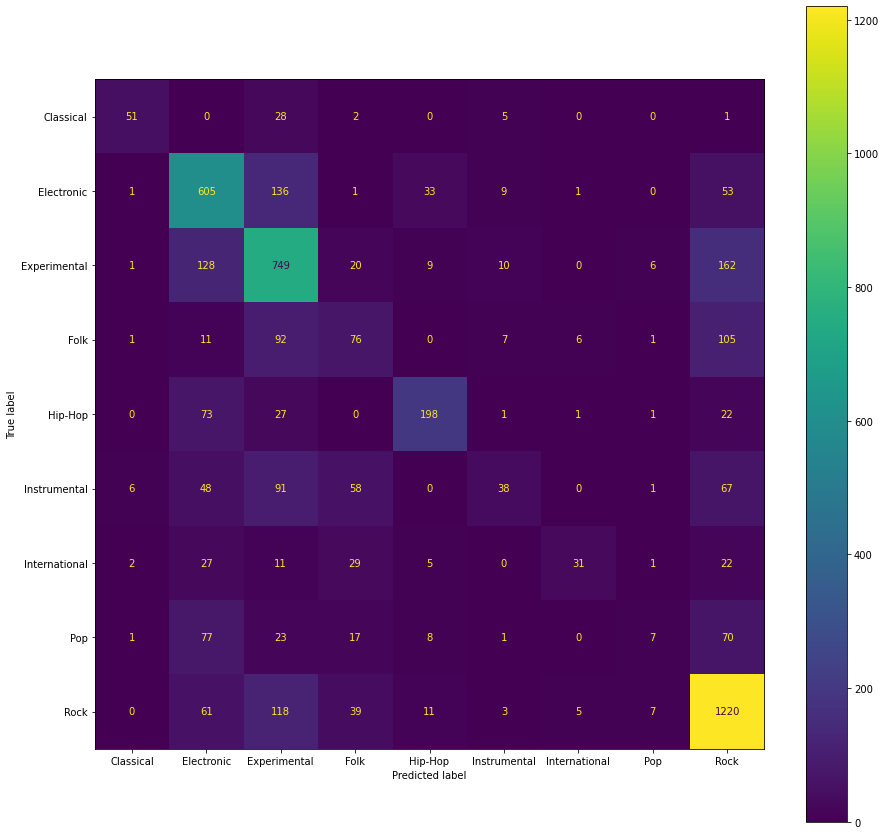

In [33]:
# train with PCA - CatBoost
cat_clf_best.fit(X_train, y_train, [])
y_pred = cat_clf_best.predict(X_validation)
y_pred_proba = cat_clf_best.predict_proba(X_validation)

model = 'CatBoost(w PCA)'
accuracy = round(metrics.accuracy_score(y_test, y_pred),4)
precision = round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
recall = round(metrics.recall_score(y_test, y_pred, average='weighted'),4)
f1_score =  round(metrics.f1_score(y_test, y_pred, average='weighted'),4)
ROCAUC = round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4)
new_row = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score, 'ROCAUC': ROCAUC}
df_metrics = df_metrics.append(new_row, ignore_index=True)

print('\n---CatBoost on full subset w over sampling---')
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('f1 score:', f1_score)
print('AUC:', ROCAUC)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cat_clf_best, X_validation, y_validation, ax=ax) 

In [122]:
df_metrics

,model,accuracy,precision,recall,f1_score,ROCAUC
0,test_small,0.6150,0.6163,0.6150,0.6144,0.9083
1,CatBoost(no sampling),0.6568,0.6329,0.6568,0.6298,0.9085
2,CatBoost(over sampling),0.6477,0.6492,0.6477,0.6473,0.9048
3,CatBoost(under sampling),0.5821,0.6381,0.5821,0.6005,0.8867
4,CatBoost(over sampling),0.6353,0.6466,0.6353,0.6394,0.9020
5,Random Forest(w hyperparemeter tuning),0.6243,0.5756,0.6243,0.5761,0.8828
6,XGBoost(w hyperparemeter tuning),0.6650,0.6317,0.6650,0.6292,0.9025
7,CatBoost(w hyperparemeter tuning),0.6811,0.6536,0.6811,0.6519,0.9103
8,Random Forest(w PCA),0.5397,0.4651,0.5397,0.4678,0.8571
9,XGBoost(w PCA),0.6011,0.5787,0.6011,0.5644,0.8759


#### Multiclass ROC Curve

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ovr_tree_full = OneVsRestClassifier(cat_clf_best)

feature_train_full = X_train
label_train_full = y_train
ovr_tree_full.fit(feature_train_full, label_train_full)

In [47]:
feature_test_full = X_test
label_test_full = y_test
label_pred_ovr_tree_full = ovr_tree_full.predict(feature_test_full)
label_pred_ovr_tree_probability = ovr_tree_full.predict_proba(feature_test_full)
labelNames = ['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 'Instrumental', 'International', 'Classical']
labelNames.sort()

In [48]:
fpr = {}
tpr = {}
thresh ={}

n_class = 9

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(label_test_full, label_pred_ovr_tree_probability[:,i], pos_label=labelNames[i])

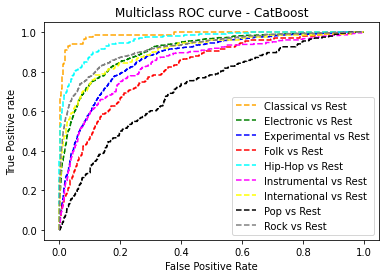

In [54]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Classical vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Electronic vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Experimental vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Folk vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='cyan', label='Hip-Hop vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Instrumental vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='International vs Rest')
plt.plot(fpr[7], tpr[7], linestyle='--',color='black', label='Pop vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='grey', label='Rock vs Rest')
plt.title('Multiclass ROC curve - CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC - CatBoost',dpi=300);

#### To check top3 accuracy

In [109]:
# DataFrame for storing top3 results
predict_col = ['p1', 'p2', 'p3']
df_predict = pd.DataFrame(columns = predict_col)

In [110]:
sorted_class = ['Classical', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
np.argmax(y_pred_proba[0])

count=0
for i in range(y_pred_proba.shape[0]):
    score = y_pred_proba[i]
    #print("Index: {}   Actual: {}   Predict: {}".format(y_test.index[i], y_test.iloc[i], sorted_class[np.argmax(score)]))
    #print("Top 3 predictions")
    sorted_a = np.argsort(-score, axis=-1, kind='quicksort', order=None)
    
    top3 = sorted_a[:3]
    for x in top3:
        #print("{}%".format(np.round(100 * np.max(score[x]),2)), sorted_class[x])
        if x == 0:
            count+=1
    #print()
    
    actual =  y_test.iloc[i]
    predict1 = sorted_class[sorted_a[0]]
    predict2 = sorted_class[sorted_a[1]]
    predict3 = sorted_class[sorted_a[2]]
    new_row = {'actual': actual, 'p1': predict1, 'p2': predict2, 'p3': predict3}
    df_predict = df_predict.append(new_row, ignore_index=True)

In [114]:
df_predict.actual == df_predict.p1

0        True
1       False
2        True
3        True
4        True
        ...  
4733    False
4734    False
4735    False
4736    False
4737    False
Length: 4738, dtype: bool

In [115]:
mask = df_predict.eq(df_predict.pop('actual'), axis=0).any(axis=1)

In [116]:
mask.value_counts()

True     4260
False     478
dtype: int64

In [117]:
mask.shape

(4738,)

#### Top 3 accuracy returns ~ 90% accuracy. This suggest the models can help to suggest top 3 most probable genres for the human classifier to select from, instead of the human having to choose from the whole list of genre. The Predicted probabilities can also be provided in a reverse sorted order for easier classfication.

In [118]:
4260/4738

0.8991135500211059

### To test model based on different level of variance(To explain why PCA may not give better results)

In [125]:
from sklearn.feature_selection import VarianceThreshold
def set_threshold(val):
    df = preprocess(features)
    
    # Keep needed features, to be added back after PCA
    genre_top = df.genre_top
    index = df.index
    split = df.split
    subset = df.subset
    df = df.drop(columns=['genre_top', 'split', 'subset'])
    
    thresholder = VarianceThreshold(threshold=val)
    reduced = thresholder.fit_transform(df)
    df = pd.DataFrame(reduced)
    df.index = index
    df = pd.concat([df, genre_top, split, subset], axis=1)
    
    df_train = df[df.split == 'training']
    df_test = df[df.split == 'test']
    X_train = df_train.drop(columns=['genre_top', 'split', 'subset'])
    y_train = df_train['genre_top']
    X_test = df_test.drop(columns=['genre_top', 'split', 'subset'])
    y_test = df_test['genre_top']
     
    print(X_train.shape)

    return X_train, X_test, y_train, y_test

(38385, 518)

---CatBoost on full dataset (var_threshold=1.0) ---
accuracy: 0.6577
precision: 0.6393
recall: 0.6577
f1 score: 0.6336
AUC: 0.9087


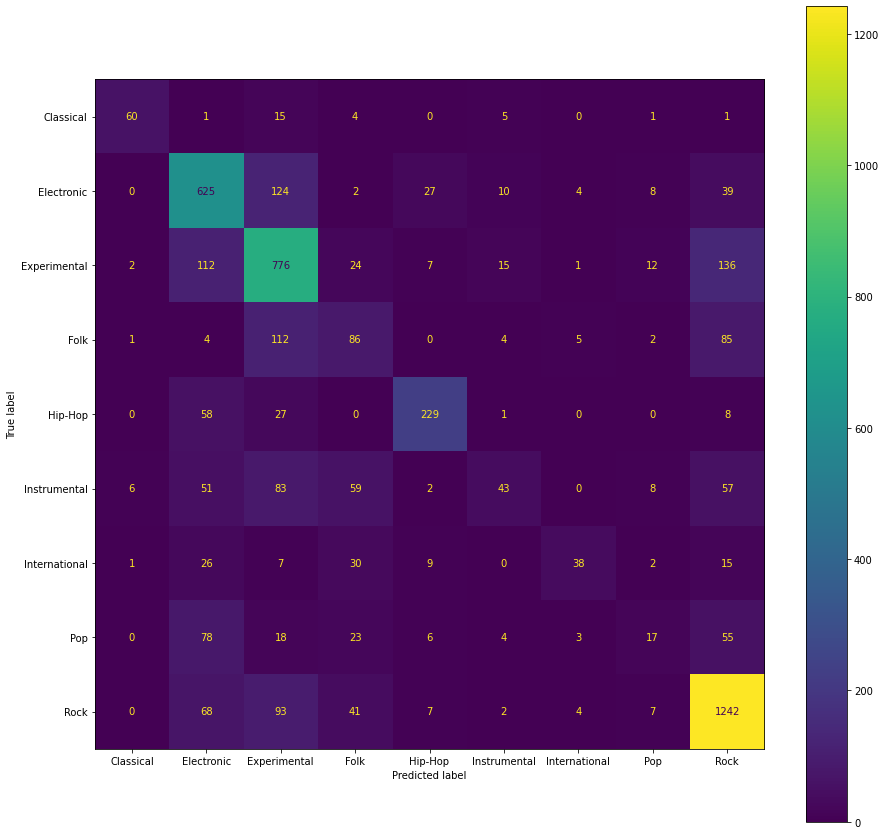

In [126]:
#train and test on 0.95var, 0.05var and full small dataset
X_train, X_test, y_train, y_test = set_threshold(0)
model_0 = CatBoostClassifier(learning_rate=0.1, l2_leaf_reg = 5, depth = 6, verbose=False)
model_0.fit(X_train, y_train, [])
y_pred = model_0.predict(X_test)
y_pred_proba = model_0.predict_proba(X_test)

print('\n---CatBoost on full dataset (var_threshold=1.0) ---')
print('accuracy:', round(metrics.accuracy_score(y_test, y_pred),4))
print('precision:', round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('recall:', round(metrics.recall_score(y_test, y_pred, average='weighted'),4))
print('f1 score:', round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4))
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(model_0, X_test, y_test, ax=ax) 

(38385, 302)

---CatBoost on full dataset (var_threshold=0.95)---
accuracy: 0.6499
precision: 0.628
recall: 0.6499
f1 score: 0.6261
AUC: 0.9027


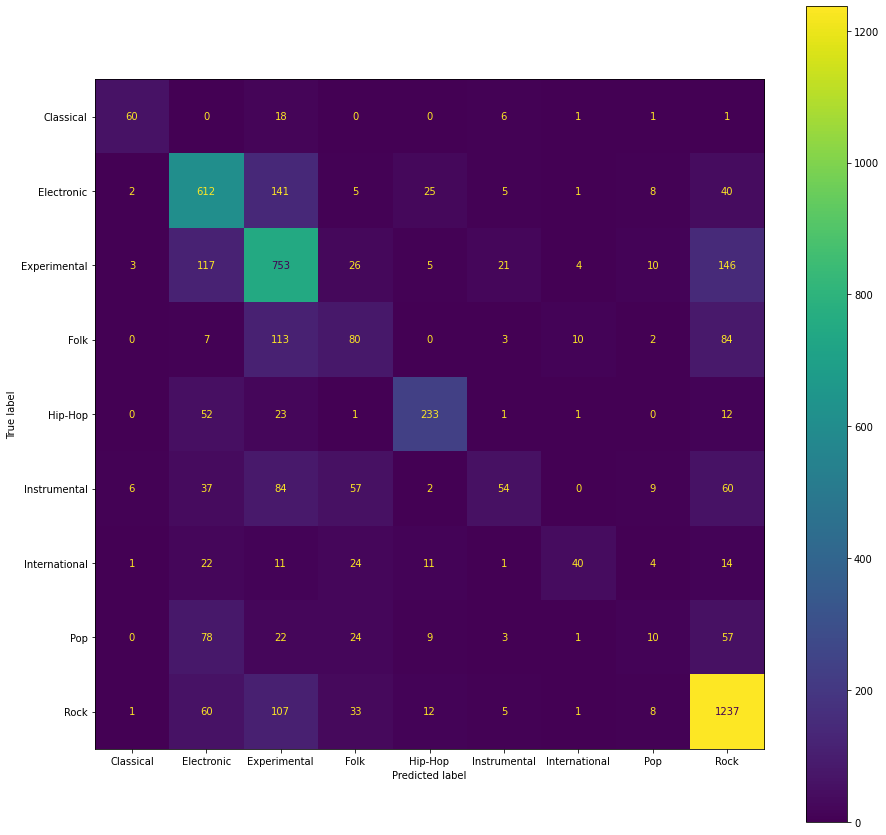

In [127]:
#train and test on 0.95var, 0.05var and full small dataset
X_train, X_test, y_train, y_test = set_threshold(0.05)
model_005 = CatBoostClassifier(learning_rate=0.1, l2_leaf_reg = 5, depth = 6, verbose=False)
model_005.fit(X_train, y_train, [])
y_pred = model_005.predict(X_test)
y_pred_proba = model_005.predict_proba(X_test)

print('\n---CatBoost on full dataset (var_threshold=0.95)---')
print('accuracy:', round(metrics.accuracy_score(y_test, y_pred),4))
print('precision:', round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('recall:', round(metrics.recall_score(y_test, y_pred, average='weighted'),4))
print('f1 score:', round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4))
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(model_005, X_test, y_test, ax=ax) 

(38385, 299)

---CatBoost on full dataset (var_threshold=0.9)---
accuracy: 0.6456
precision: 0.6205
recall: 0.6456
f1 score: 0.6205
AUC: 0.9031


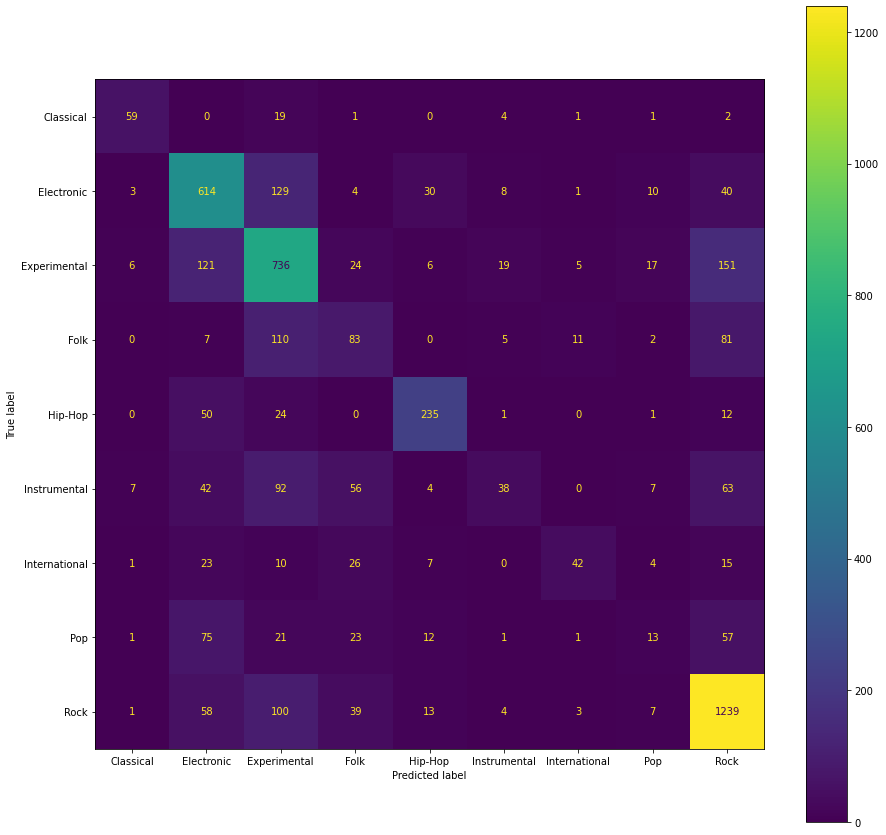

In [129]:
#train and test on 0.95var, 0.05var and full small dataset
X_train, X_test, y_train, y_test = set_threshold(0.1)
model_01 = CatBoostClassifier(learning_rate=0.1, l2_leaf_reg = 5, depth = 6, verbose=False)
model_01.fit(X_train, y_train, [])
y_pred = model_01.predict(X_test)
y_pred_proba = model_01.predict_proba(X_test)

print('\n---CatBoost on full dataset (var_threshold=0.9)---')
print('accuracy:', round(metrics.accuracy_score(y_test, y_pred),4))
print('precision:', round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('recall:', round(metrics.recall_score(y_test, y_pred, average='weighted'),4))
print('f1 score:', round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4))
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(model_01, X_test, y_test, ax=ax) 

(38385, 239)

---CatBoost on full dataset (var_threshold=0.5) ---
accuracy: 0.6463
precision: 0.623
recall: 0.6463
f1 score: 0.6219
AUC: 0.9006


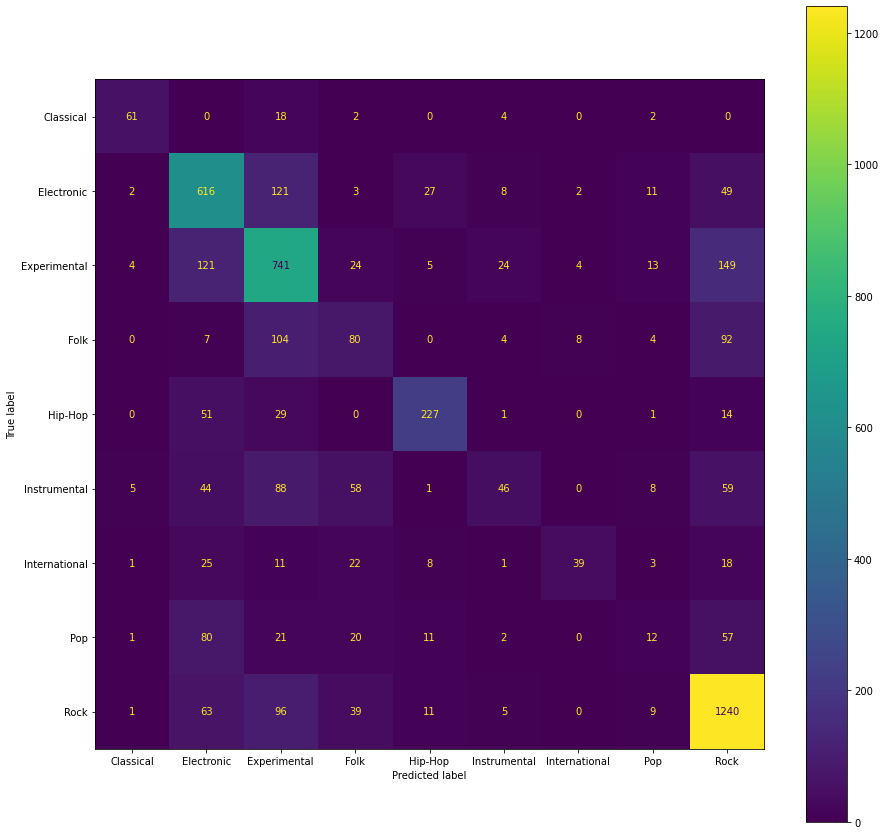

In [130]:
#train and test on 0.95var, 0.05var and full small dataset
X_train, X_test, y_train, y_test = set_threshold(0.5)
model_05 = CatBoostClassifier(learning_rate=0.1, l2_leaf_reg = 5, depth = 6, verbose=False)
model_05.fit(X_train, y_train, [])
y_pred = model_05.predict(X_test)
y_pred_proba = model_05.predict_proba(X_test)

print('\n---CatBoost on full dataset (var_threshold=0.5) ---')
print('accuracy:', round(metrics.accuracy_score(y_test, y_pred),4))
print('precision:', round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('recall:', round(metrics.recall_score(y_test, y_pred, average='weighted'),4))
print('f1 score:', round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'),4))
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(model_05, X_test, y_test, ax=ax) 

~200 features are sufficient to build a decent model, but features with low variance are still useful to provide the marginal improvement to obtain the best model. 